In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pprint import pprint    # 출력 값 보기 편하게 만들어줌

In [2]:
LABEL_INT_DICT = np.unique(pd.read_csv('D:/data_ai/5_AI/ucf11_train_vid.csv')['label'])
pprint(LABEL_INT_DICT)
LABEL_STR_DICT = {k:v for v, k in enumerate(LABEL_INT_DICT)}    # KEY값과 VALUE값 바꿈
pprint(LABEL_STR_DICT)

array(['biking', 'diving', 'golf', 'juggle', 'jumping', 'riding',
       'shooting', 'spiking', 'swing', 'tennis', 'walk'], dtype=object)
{'biking': 0,
 'diving': 1,
 'golf': 2,
 'juggle': 3,
 'jumping': 4,
 'riding': 5,
 'shooting': 6,
 'spiking': 7,
 'swing': 8,
 'tennis': 9,
 'walk': 10}


In [3]:
import albumentations as A
import tensorflow as tf
from tensorflow import keras
import random

In [4]:
import math

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, image_size, mode='train', shuffle=True):
        self.mode = mode
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.image_size = image_size
        
        if self.mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                    )
            ])
            
        self.img_paths = glob(f'D:/data_ai/5_AI/UCF11_updated_png/{mode}/*.png')
        
    def __len__(self):
        return math.ceil(len(self.img_paths) / self.batch_size)

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        data = self.img_paths[start:end]    # iloc 왜 안해주지? 6_트레이닝 스크립트 구현에서는 해줬는데
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)


    def get_data(self, data):
        batch_x = []
        batch_y = []

        for img_path in data:             
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.image_size, self.image_size))

            if self.mode == 'train':
                augmented = self.transform(image=img)
                img = augmented['image']

            img = img.astype('float32')
            img = img / 255

            label = img_path.split('\\')[-1].split('_')[0]
            label = LABEL_STR_DICT[label]

            batch_x.append(img)
            batch_y.append(label)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.img_paths)

In [5]:
train_generator = DataGenerator(
    mode='train',
    batch_size=128,
    image_size=256,
    shuffle=True
)

valid_generator = DataGenerator(
    mode='valid',
    batch_size=128,
    image_size=256,
    shuffle=True
)

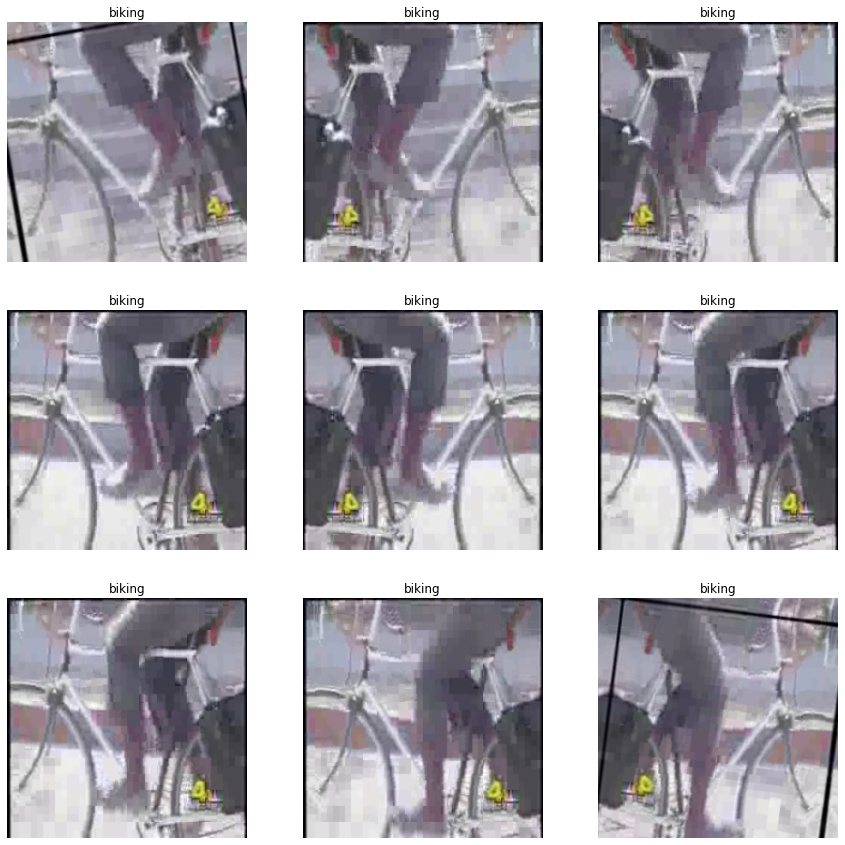

In [6]:
for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.title(LABEL_INT_DICT[y[i]])
        plt.axis('off')
    break

In [7]:
# !pip install tensorflow-hub

In [8]:
# tensorflow hub를 사용
# https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
# activation : softmax

# optimizer : adam
# loss : sparse_categorical_crossentropy
# metrics : accuracy

import tensorflow_hub as hub
import os

model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2',
         trainable=True),
    tf.keras.layers.Dense(len(LABEL_INT_DICT), activation='softmax')
])

model.build([None, 256, 256, 3])    # batch input shape

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dense (Dense)               (None, 11)                14091     
                                                                 


c:\program files\python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total params: 5,933,403
Trainable params: 5,872,795
Non-trainable params: 60,608
_________________________________________________________________


In [9]:
# ucf11_weights 디렉토리 생성
# 한번만 실행 가능
# 두번실행하면 동일한 파일때문에 에러남

# os.mkdir('D:/data_ai/5_AI/ucf11_weights')

In [10]:
# ucf11_weights 안에 학습데이터를 저장
filepath = 'D:/data_ai/5_AI/ucf11_weights/{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min'
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1,
    callbacks=[
        model_checkpoint
    ]
    
)

# 실행 에러
# 에러 제일 밑에 출력된 폴더 위치로 가서 캐시파일 지우면 다시 모델 받고 돌아갑니다
# 우분투 설치 -> 도커 설치 -> 돌리면 상당히 빠르다고 지인에게 들었습니다. 참고!!



# 학습



Epoch 1/10


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[128,16,16,672] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node conv2d/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_45725]